In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Neural Network Baseline
Traditional, simple neural network model with no NAICS features (no entity embeddings).  Use the dataset with no Nulls

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_nn.sba_nn import sbnn_metrics 

## Input Data

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
features = [f for f in imputer_features if 'NAICS' not in f]
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


##### Datasets for train, validation

In [10]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features].set_index('LoanNr_ChkDgt').sort_index()

In [11]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [12]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [13]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Function to create model

In [14]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [15]:
this_model = create_model()

2024-05-16 17:02:35.737168: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-16 17:02:35.737235: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-16 17:02:35.737253: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-16 17:02:35.737318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-16 17:02:35.737366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-05-16 17:02:36.598668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - ETA: 0s - loss: 0.4727 - auc: 0.3029 - auc_1: 0.6713

2024-05-16 17:05:25.187998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 192s 13ms/step - loss: 0.4727 - auc: 0.3029 - auc_1: 0.6713 - val_loss: 0.4659 - val_auc: 0.3285 - val_auc_1: 0.6913
Epoch 2/20
13964/13964 [==============================] - 162s 12ms/step - loss: 0.4664 - auc: 0.3195 - auc_1: 0.6851 - val_loss: 0.4639 - val_auc: 0.3358 - val_auc_1: 0.6969
Epoch 3/20
13964/13964 [==============================] - 105s 8ms/step - loss: 0.4653 - auc: 0.3237 - auc_1: 0.6881 - val_loss: 0.4637 - val_auc: 0.3367 - val_auc_1: 0.6977
Epoch 4/20
13964/13964 [==============================] - 104s 7ms/step - loss: 0.4647 - auc: 0.3267 - auc_1: 0.6896 - val_loss: 0.4637 - val_auc: 0.3395 - val_auc_1: 0.6988
Epoch 5/20
13964/13964 [==============================] - 102s 7ms/step - loss: 0.4642 - auc: 0.3277 - auc_1: 0.6914 - val_loss: 0.4634 - val_auc: 0.3388 - val_auc_1: 0.6985
Epoch 6/20
13964/13964 [==============================] - 104s 7ms/step - loss: 0.4640 - auc: 0.3289 - auc_1: 0.6920 - val_loss: 0.4629 - v

In [18]:
this_history_df = pd.DataFrame(this_history.history)

In [19]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [20]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [21]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_fit_history.csv'))

<Axes: >

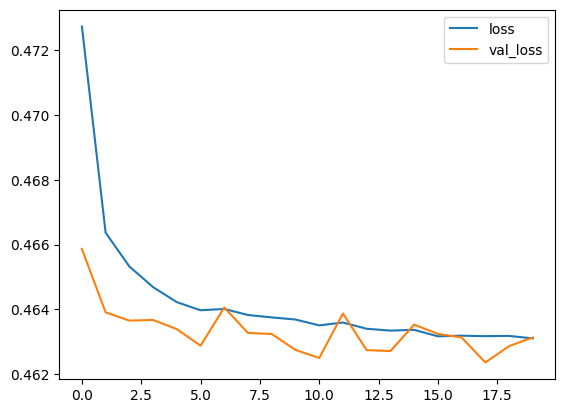

In [22]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

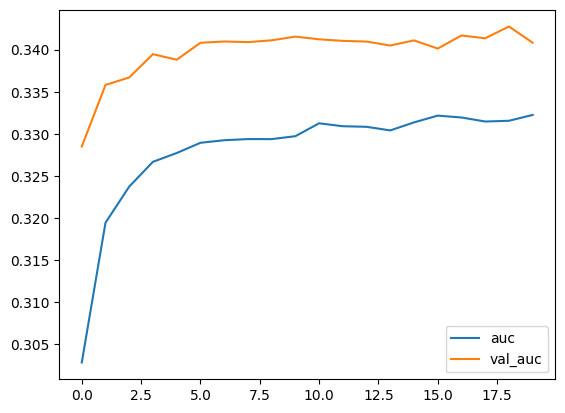

In [23]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

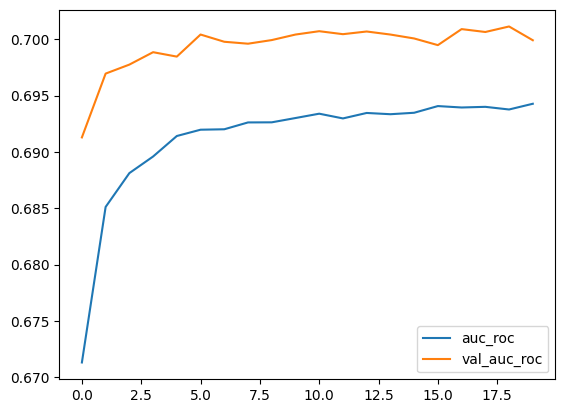

In [24]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [25]:
this_model.save(Path(setup.temp_path).joinpath('02_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [26]:
all_predictions = this_model.predict(X.drop(columns='dset'))

  144/21735 [..............................] - ETA: 22s

2024-05-16 18:14:31.959905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 23s 1ms/step


In [27]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [28]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.00000,0.27851
target,0.27851,1.00000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [29]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [31]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [32]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.425436
11,0.22,0.423951
9,0.18,0.423092


In [33]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [34]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [35]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.500797
0    0.499203
Name: proportion, dtype: float64

In [36]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('02_DATA_predictions.parquet'))

## Metrics

In [37]:
all_predictions_df = pd.read_parquet(Path(setup.temp_path).joinpath('02_DATA_predictions.parquet'))

In [38]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.607345,0.432086,0.305037,0.740509,0.344488,0.706232,NaN
1,train,0.593947,0.425436,0.298034,0.743086,0.338112,0.698037,NaN
2,val,0.597820,0.429965,0.302325,0.744137,0.340985,0.699965,NaN
0,test,0.595718,0.426621,0.299660,0.740252,0.339469,0.696893,0.0
1,test,0.626672,0.441664,0.314594,0.740944,0.353954,0.721698,1.0
